# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [ ]:
import pandas as pd
import matplotlib as plt

#импорт данных
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print  (data.head(5)) 
print(data.info())
print(data.hist(figsize=(15, 20)))

### Предобработка данных

In [35]:
#подсчет нулевых значений и удаление или замены пустых значений 
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['ponds_around3000']=data['ponds_around3000'].fillna(0)
data['balcony']=data['balcony'].fillna(0)
data['is_apartment']=data['is_apartment'].fillna(0)
data['days_exposition']=data['days_exposition'].fillna(0)
data['floors_total']=data['floors_total'].fillna(data['floors_total'].median())
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total                0
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition             0
price_one_areal             0
dtype: int64

Наличие балкона, аэропорта, парка и пруда в ближайшей окрастности может не быть, поэтому нулевые значения мы заполняем нулем. Можно пердположить, что это связанно с тем, что они правда отсутствуют в квартире, как балконы, или по близости есть объекты с расстоянием в 0 в случае с прудом, аэропортом и парком. Остальные значения осталяем пустыми, так что они могут значительно повлиять на анализ. Их отсутсвия могут быть связаны с невнимательностью продавцов, неуверенности в том, что нужно указать или багов сервиса. 

In [36]:
#изменение типов данных

data=data.astype({'balcony':'int','is_apartment':'bool','parks_around3000':'int',\
                 'ponds_around3000':'int','days_exposition':'int','floors_total':'int'})
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y%m%dT%H:%M:%S')

data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                  float64
ponds_around3000                 int64
ponds_nearest                  float64
days_exposition                  int64
price_one_areal                float64
dtype: object

В столбце first_day_exposition меняем тип данных на дату, так как это так как является количеством.
is_apartment меняем на bool, так как являет присваеванием статсута(то есть является или не является апартаментами). 
parks_around3000, ponds_around3000 меняется на int, так ка описывает количество парков или прудов на расстоянии 3000 м. 
days_exposition является количеством, поэтому также присваиваем тип int

**Устраним дубликаты в столбце 'locality_name'**

In [37]:
data = data.drop_duplicates()
#проверка значений на уникальность
data['locality_name'].unique()
data['locality_name']=data['locality_name'].str.lower()
data['locality_name']=data['locality_name'].str.replace('ё','е')
data['locality_name']=data['locality_name'].str.replace('поселок городского типа','поселок')
data['locality_name']=data['locality_name'].str.replace('городской поселок','поселок')
data['locality_name']=data['locality_name'].str.replace('коттеджный поселок','поселок')
data['locality_name'].unique()

array(['санкт-петербург', 'поселок шушары', 'поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок красный бор', 'гатчина', 'деревня федоровское', 'выборг',
       'кронштадт', 'кировск', 'деревня новое девяткино',
       'поселок металлострой', 'поселок лебяжье', 'поселок сиверский',
       'поселок молодцово', 'поселок кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок ефимовский', 'поселок плодовое', 'деревня заклинье',
       'поселок торковичи', 'поселок первомайское', 'красное село',
       'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет', 'сланцы',
       'село путилово', 'ивангород', 'мурино', 'шлиссельбург',
       'никольское', 'зелено

In [38]:

print(data.describe())

#Максимальное значение площади квартиры
#print(data.query('total_area == 900'))

#Значение квартир с максимальным количеством комнат
#print(data.query('rooms == 19'))
#print(data.sort_values(by='rooms',ascending=False).head(5))

 


       total_images    last_price    total_area         rooms  ceiling_height  \
count  23699.000000  23699.000000  23699.000000  23699.000000    14504.000000   
mean       9.858475      6.541549     60.348651      2.070636        2.771499   
std        5.682529     10.887013     35.654083      1.078405        1.261056   
min        0.000000      0.012190     12.000000      0.000000        1.000000   
25%        6.000000      3.400000     40.000000      1.000000        2.520000   
50%        9.000000      4.650000     52.000000      2.000000        2.650000   
75%       14.000000      6.800000     69.900000      3.000000        2.800000   
max       50.000000    763.000000    900.000000     19.000000      100.000000   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23699.000000  21796.000000  23699.000000  21421.000000  23699.000000   
mean      10.667750     34.457852      5.892358     10.569807      0.591080   
std        6.585961     22.030445

 Рассмотрим все данные в целом по столбцам:
   - total_images. Минимальное значение 0, максимальное значение 50, среднее 9. Количество фотографий зависит от заинтересованности публикующего, поэтому не думаю можно не считать их аномальными </p> 
   - last_price. Минимальные, максимальные и средние значения не сильно отличаются, данные нормальные, аномалии отсутствуют 
   - total_area. Минимальное значение 12, максимальное 900. Максимальное значения сильно отличается от среднего и минимального значения, поэтому рассмотрим его подробнее. Количество комнат в квартире 12, площадь жилой площади 409.7, а площадь кухни 112.0. Думаю это значения является правдой и не стоит исключать его из исследования </p>
   - rooms. Максимальное количество комант 19, это достаточно аномальное значение для квартиру, поэтому также рассмотрим его подробнее и поймем, что для площадь 374.6 кв. м. это досточно большое количество. Также посмотрим отсортируем список по возрастанию, чтобы сравнить с остальными примерами. На общем фоне данный показатель не кажется необычным, поэтому оставим его в наборе
   - ceiling_height. Максимальная высота потолков 100 м, что является странным показателем. В среднем высота потолков меньше 3 кв. м. Однако, среднее и мединные значения не сильно отличаются, поэтому показательно можно оставить, так как он не повлияет на исследование
   - floors_total. Данные в норме.
   - living_area. Значения в норме, можно также сравнить каждую жилую площадь с общей площадью квартиры, чтобы она не привышала значения. 
   - floor. Вплоне нормальные, особенно с учетом общего количества этажей в домах.
   - kitchen_area. Аналогично жилой площади можно считать нормальными.
   - balcony. Данные в норм.
   - Значения в столбцах airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_nearest также имеют нормальное распределения, пока не вижу смысла их менять.


### Посчитайте и добавьте в таблицу новые столбцы

In [39]:
data_new=data
#стоимость 1 кв м 
data_new['price_one_areal']=data['last_price']/data['total_area']
#месяц публикации
data_new['first_month_exposition']=data_new['first_day_exposition'].dt.month
#год публикации
data_new['first_year_exposition']=data_new['first_day_exposition'].dt.year
#номер дня недели
data_new['first_week_exposition']=data_new['first_day_exposition'].dt.weekday
#функция название этажа 
def floor_name (data):
    floors_last = data['floors_total']
    floor = data['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_last:
        return 'последний'
    elif 1 < floor < floors_last:
        return 'другой'
    
data_new['floor_name']=data_new.apply(floor_name, axis = 1)
#расстояние для центра города в км
data_new['Centers_nearest_km']=data['cityCenters_nearest']/1000
#просмотр нового набора данных
print(data_new.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20      13.000       108.0           2019-03-07      3   
1             7       3.350        40.4           2018-12-04      1   
2            10       5.196        56.0           2015-08-20      2   
3             0      64.900       159.0           2015-07-24      3   
4             2      10.000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1             NaN            11         18.6      1         False  ...   
2             NaN             5         34.3      4         False  ...   
3             NaN            14          NaN      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0                 2          755.0         

first_year_exposition
2014     108407
2015     726448
2016     871152
2017    1258772
2018     713195
2019      33499
Name: days_exposition, dtype: int64

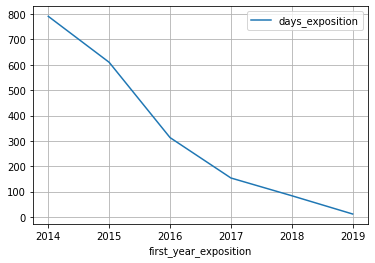

In [57]:
data_new.pivot_table(index='first_year_exposition', values='days_exposition').plot( grid=True)
data_new.groupby(by=['first_year_exposition'])['days_exposition'].sum()

In [ ]:
По графику видно, что количество дней уменьшается с каждым годом.

### Проведите исследовательский анализ данных

count    2.369900e+04
mean     6.541549e-06
std      1.088701e-05
min      1.219000e-08
25%      3.400000e-06
50%      4.650000e-06
75%      6.800000e-06
max      7.630000e-04
Name: last_price, dtype: float64


<AxesSubplot:ylabel='Frequency'>

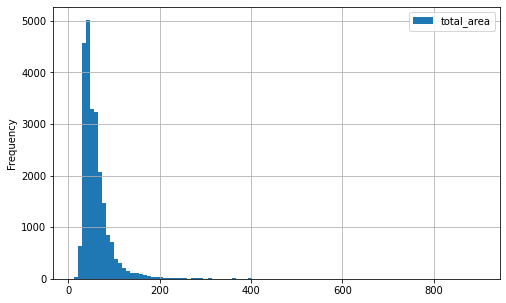

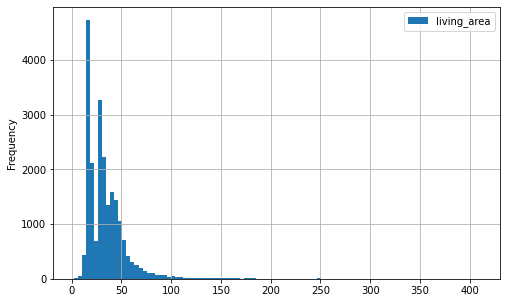

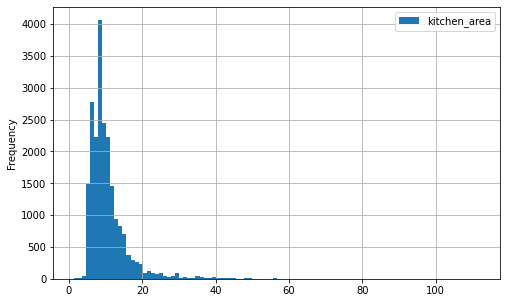

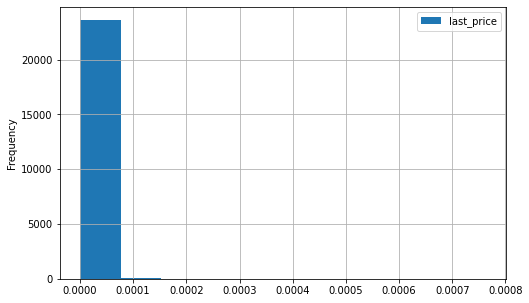

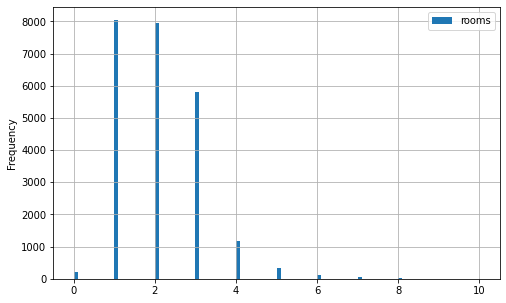

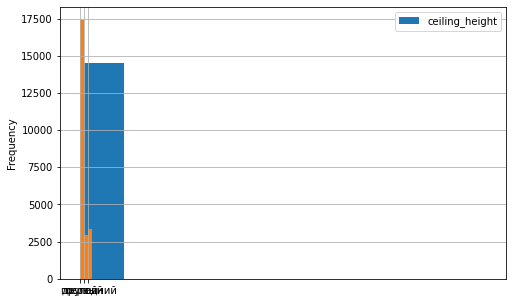

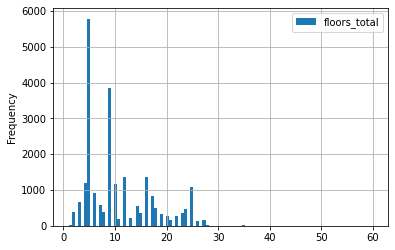

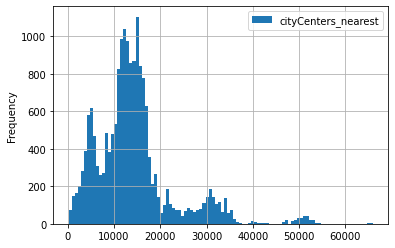

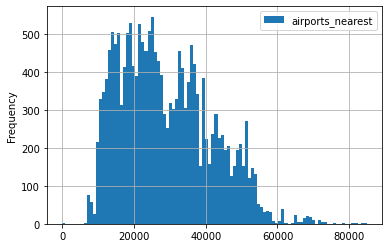

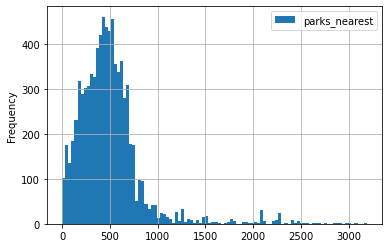

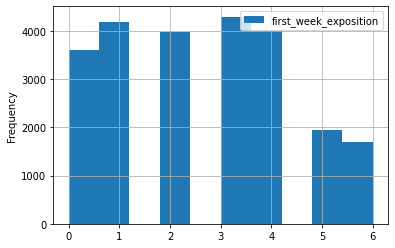

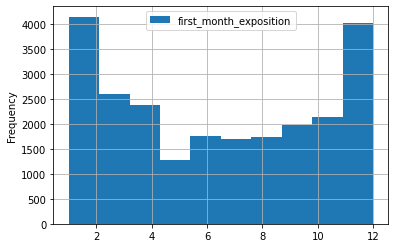

In [41]:
#анализ общей площади 
data_new.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True,figsize=(8,5))

#анализ жилой площади
data_new.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True,figsize=(8,5))

#анализ площади кухни
data_new.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True,figsize=(8,5))

#анализ цены объектов 
data_new['last_price']=data_new['last_price']/1000000
data_new.plot(y = 'last_price', kind = 'hist', grid=True,figsize=(8,5))
print(data['last_price'].describe())

#анализ количеств комнат
data_new.plot(y = 'rooms', kind = 'hist', bins = 100, grid=True,figsize=(8,5), range = (0,10))

#анализ высоты потолков
data_new.plot(y = 'ceiling_height', kind = 'hist', grid=True,figsize=(8,5))

#анализ этажей квартир
data_new['floor_name'].hist(range = (0,10))

#анализ этажей квартиры 
data_new.plot(y = 'floors_total', kind = 'hist', bins = 100, grid=True)

#анализ расстояние до центра города в метрах 
data_new.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 100, grid=True)

#анализ расстояние до ближайшего аэропорта 
data_new.plot(y = 'airports_nearest', kind = 'hist', bins = 100, grid=True)

#анализ расстояние до ближайшего парка 
data_new.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True)

#анализ дня публикации объявления
data_new.plot(y = 'first_week_exposition', kind = 'hist', grid=True)

#анализ месяца публикации объявления
data_new.plot(y = 'first_month_exposition', kind = 'hist',  grid=True)

Из полученных диаграмма можно сделать выводы: 
- Общая площадь. Данные имеют нормальное распределение, есть небольшие выбросы. Большая часть квартир имеет общую площадь меньше 200 м2
- Жилая площадь. Данный парметр имеет такие же показатели, как и общая площадь. В основном квартиры имеет площадь до 50 м2
- Площадь кухни. Площади квартир имеют большое разнообразие, но большая часть квартир имеет площадь от 0 до 20 м2
- Цены объектов. Средняя стоимость квартир составляет 65 млн. рублей, самая дорогастоящая квартира стоит 76 млдр. рублей. Чаще всего люди покупают квартиры стоимостью меньше 100 млн. рублей. 
- Количество комнат. Самыми популярными квартирами являются однокомнатные и двух комнатные. 
- Тип этажа. Распределение нормальное.
- Этаж. Распределение нормальное, есть незначительные выбросы. 
- Расстояние до центра города. Распределение нормальное и вполне правдоподобное 
- Расстояние для аэропорта. Распределение нормальное 
- Дни недели. Данные показывают, что чаще всего публикации происходят в понедельник и среду
- Месяц. Чаще всегопродажа квартир произсходит в первый и последний месяц года

***Изучения показателей скорости удаления объявлений***


count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64
45    880
60    538
7     234
30    208
90    204
Name: days_exposition, dtype: int64


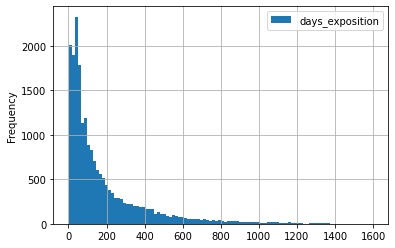

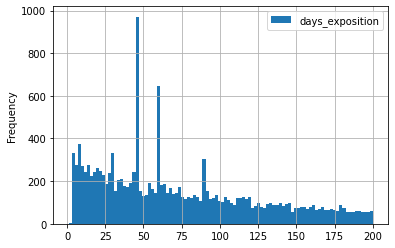

In [42]:

print(data_new[data_new['days_exposition']!=0]['days_exposition'].describe())
data_new.plot(y = 'days_exposition', kind = 'hist', grid=True,bins=100, range=(1,1600))
data_new.plot(y = 'days_exposition', kind = 'hist', grid=True, range=(1,200), bins=100)
print(data[data['days_exposition']!=0]['days_exposition'].value_counts().head(5))

Анализ удаления объявлений. 
- Среднее значение 180 дней, медианное значение 95 дней. 
- По гистограмме видно, что распределение нормальное. Большое количество приходится на промежуток между 0 и 200 днями. Для более точного анализа мы увеличили этот промежуток, чтобы увидеть более популярными является 45,60,7,30 и 90 дней после публикации. 
- Исключая объявления, которые не продержали и дня, так как такой быстрый срок удаления скорее всего связан с ошибочными данными и удаления самим автором или удаления самой платформой в связи с нарушениями правил. 

Из этого можно сделать вывод, что обычно продажа занимает 95 дней. Самой быстрой продажей является 1 день, а самым долгим периодом продажи 1580 дней. 


***Какие факторы больше всего влияют на общую (полную) стоимость объекта?***

Корреляция: 0.6536750579657244


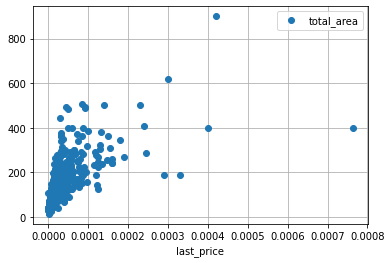

In [43]:
#Зависимость общей стоимости квартиры от площади квартиры 

data_new.pivot_table(index='last_price', values='total_area').plot(style = 'o', grid=True)

print('Корреляция:', data_new['total_area'].corr(data_new['last_price']) )

Корреляция является среднее и стоимость квартиры зависит от общей площади. Если смотреть на диаграмму, 
то она возрастающая: с увеличением квадратных метров, стоимость возрастает. Также по диаграмме рассеяния зависимость слабая

Корреляция: 0.5664915336952651


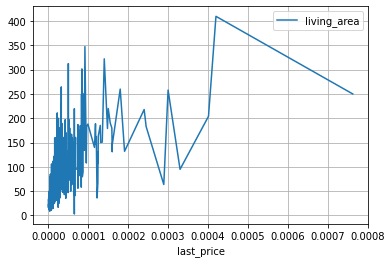

In [44]:
#Зависимость жилой площади от стоимости 

data_new.pivot_table(index='last_price', values='living_area').plot(grid=True)
print('Корреляция:', data_new['living_area'].corr(data_new['last_price']) )

Корреляция, как в случае с общей площадью 0,6 средняя, зависимость также возрастающая. 

Корреляция: 0.5198690130216387


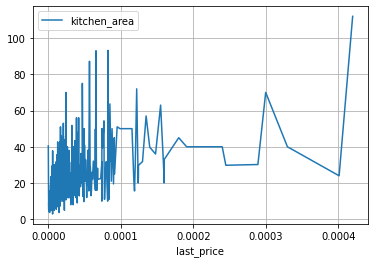

In [45]:
#Зависимость площади кухни от стоимости 

data_new.pivot_table(index='last_price', values='kitchen_area').plot(grid=True)
print('Корреляция:', data_new['kitchen_area'].corr(data_new['last_price']) )

Корреляция при данном сравнении меньше, но не сильно слабее, следовательно и зависимость такая же. 

       total_images  last_price  total_area first_day_exposition  rooms  \
0                20    0.000013      108.00           2019-03-07      3   
1                 7    0.000003       40.40           2018-12-04      1   
2                10    0.000005       56.00           2015-08-20      2   
3                 0    0.000065      159.00           2015-07-24      3   
4                 2    0.000010      100.00           2018-06-19      2   
...             ...         ...         ...                  ...    ...   
23694             9    0.000010      133.81           2017-03-21      3   
23695            14    0.000003       59.00           2018-01-15      3   
23696            18    0.000003       56.70           2018-02-11      2   
23697            13    0.000011       76.75           2017-03-28      2   
23698             4    0.000001       32.30           2017-07-21      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70

<AxesSubplot:xlabel='rooms'>

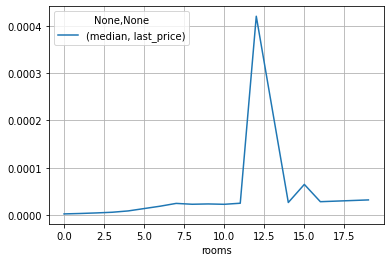

In [46]:
#Зависимость количества комнат от стоимости 
print(data_new)
data_pivot_rooms=data_new.pivot_table(index='last_price', values='rooms',aggfunc=['mean','count', 'median'])
data_pivot_rooms.columns=['mean room','count','median']

print('Топ-5 самых дорогих квартир')
print(data_pivot_rooms.sort_values(by='last_price',ascending=False).head(5))

print('Топ-5 популярных квартир по стоимости и количеству комнат')
print(data_pivot_rooms.sort_values(by='count',ascending=False).head(5))


print('Корреляция:', data_new['rooms'].corr(data_new['last_price']))
print(data_new.pivot_table(index='rooms', values='last_price',aggfunc=['median']))
data_new.pivot_table(index='rooms', values='last_price',aggfunc=['median']).plot(grid=True)

Корреляция 0,3 маленькая, следовательно, и зависимость слабая.По графику видно, что нет очевидно зависимости между стоимостью и количеством комнат. Также присутствует одно аномальное значение, как мы проверили ранее оно не является ошибочными. Возможно стоит его исключить из анализа, но тогда значения будут не точными.  

            count      mean
floor_name                 
другой      17404  0.000007
первый       2917  0.000005
последний    3341  0.000007


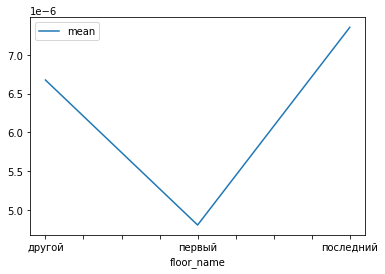

In [47]:
#Зависимость по типу этажа

data_pivot_floor_name=data_new.pivot_table(index='floor_name', values='last_price',aggfunc=['count','mean'])
data_pivot_floor_name.columns=['count','mean']
data_pivot_floor_name.plot(y='mean')
print(data_pivot_floor_name)
#print('Корреляция:', data_pivot_rooms['mean'].corr(data_pivot_rooms['count']))


По графику нет зависимости, но можно заметить, что стоимость квартир на первом этаже является самой дешевой

                       count      mean
first_week_exposition                 
0                       3612  0.000007
1                       4183  0.000006
2                       3974  0.000007
3                       4295  0.000007
4                       4000  0.000006
5                       1936  0.000007
6                       1699  0.000006


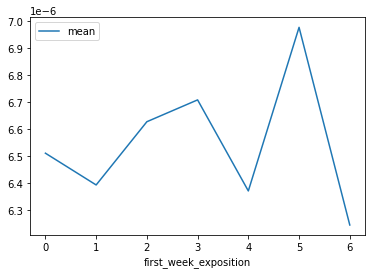

In [48]:
#Зависимость по дню

data_pivot_week=data_new.pivot_table(index='first_week_exposition', values='last_price',aggfunc=['count','mean'])
data_pivot_week.columns=['count','mean']
data_pivot_week.plot(y='mean')
print(data_pivot_week)


По данным сводной таблице видно, что средняя стоимость квартиры не зависит от дня размещения

                        count      mean
first_month_exposition                 
1                        1500  0.000007
2                        2640  0.000006
3                        2587  0.000006
4                        2379  0.000007
5                        1274  0.000007
6                        1760  0.000006
7                        1695  0.000007
8                        1744  0.000006
9                        1981  0.000007
10                       2127  0.000006
11                       2371  0.000006
12                       1641  0.000007


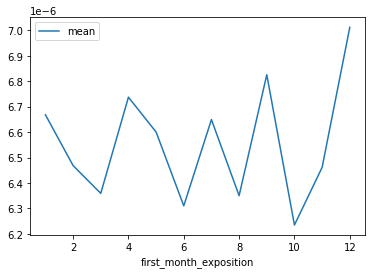

In [49]:
#Зависимость по месяцу

data_pivot_month=data_new.pivot_table(index='first_month_exposition', values='last_price',aggfunc=['count','mean'])
data_pivot_month.columns=['count','mean']
data_pivot_month.plot(y='mean')
print(data_pivot_month)

Данные сводной таблицы показывают, что стоимость квартир не равномерно колеблится, в зависимости от месяца. Однако, 
в последний месяц стоимость квартиры дороже примерно на 8%

                       count      mean
first_year_exposition                 
2014                     137  0.000012
2015                    1191  0.000009
2016                    2783  0.000007
2017                    8190  0.000007
2018                    8519  0.000006
2019                    2879  0.000007


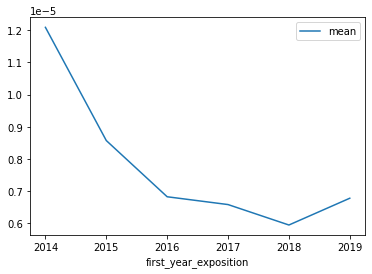

In [50]:
#Зависимость по году

data_pivot_year=data_new.pivot_table(index='first_year_exposition', values='last_price',aggfunc=['count','mean'])
data_pivot_year.columns=['count','mean']
data_pivot_year.plot(y='mean')
print(data_pivot_year)

По графику можно проследить тенденцию к снижению цен на квартиры в период с 2014 по 2018 год, 
одна с 2018 происходитрост цен на недвижимость. Пиковыми по количеству квартир, которые были выставлены на продажу,
являются 2017 и 2018 года. 

**Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name**

In [51]:
#сводная таблица со средним значением и количеством квартир
data_pivot_locality=data_new.pivot_table(index='locality_name', values='price_one_areal',aggfunc=['count','mean'])
data_pivot_locality.columns=['count','mean']

#сортировка в зависимости от нужных показателей
print('Топ 10 населенных пунктов с наибольшим числом объявлений:' )
print(data_pivot_locality.sort_values(by='count',ascending=False).head(10))
print('')
print('Пункты с самой высокой стоимостью квадратного метра:')
print(data_new.groupby(['locality_name']).agg({'price_one_areal':'mean'})\
     .sort_values(by='price_one_areal',ascending=False)\
     .head(10))
print('')
print('Пункты с самой низкой  стоимостью квадратного метра:')
print(data_new.groupby(['locality_name']).agg({'price_one_areal':'mean'})\
     .sort_values(by='price_one_areal')\
     .head(10))

Топ 10 населенных пунктов с наибольшим числом объявлений:
                   count      mean
locality_name                     
санкт-петербург    15721  0.114849
поселок мурино       556  0.085682
поселок шушары       440  0.078677
всеволожск           398  0.068654
пушкин               369  0.103126
колпино              338  0.075425
поселок парголово    327  0.090176
гатчина              307  0.068746
деревня кудрово      299  0.092474
выборг               237  0.058142

Пункты с самой высокой стоимостью квадратного метра:
                   price_one_areal
locality_name                     
зеленогорск               0.115123
санкт-петербург           0.114849
поселок репино            0.104239
пушкин                    0.103126
сестрорецк                0.101758
поселок лисий нос         0.100661
кудрово                   0.100253
деревня мистолово         0.098550
поселок левашово          0.096998
мурино                    0.092723

Пункты с самой низкой  стоимостью квадратного м

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [52]:
#создаем переменную со значениями стоимости 1 кв метра в Санкт-Петербурге
data_cityCenter= data_new[['locality_name','price_one_areal','Centers_nearest_km']]
data_cityCenter=data_cityCenter[data_cityCenter['locality_name']=='санкт-петербург']
data_cityCenter['Centers_nearest_km']=round(data_cityCenter['Centers_nearest_km'])
print(data_cityCenter.pivot_table(index='Centers_nearest_km',values='price_one_areal',aggfunc=['mean','median']))


                              mean          median
                   price_one_areal price_one_areal
Centers_nearest_km                                
0.0                       0.245834        0.172619
1.0                       0.177005        0.128485
2.0                       0.157849        0.123036
3.0                       0.121387        0.108469
4.0                       0.133283        0.117952
5.0                       0.140510        0.127093
6.0                       0.151012        0.131835
7.0                       0.156177        0.127017
8.0                       0.125671        0.122945
9.0                       0.113131        0.105814
10.0                      0.112728        0.106452
11.0                      0.108631        0.103553
12.0                      0.107489        0.103989
13.0                      0.108148        0.104082
14.0                      0.104252        0.101865
15.0                      0.104232        0.101301
16.0                      0.100

Из данных видно, что средняя стоимость увеличивается у квартир, которые находятся ближе к центру, исключая 27 и 20 км от центра города, но можно пердположить, что там находятся квартиры с большой площадью, например, загородные дома. 

### Общий вывод

Входе данного исследования мы проаализировали архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. В первом этапе мы обработали пропуски, изменили типы данных, где это требовалось. Также мы добавили требующиеся для упрощения анализ столбцы: посчитали стоимость 1 кв. метра, выделили день недели, месяц и год из даты публикации. 
Мы смогли проанализировать завимости стоимости от общей площади,жилой площади,площади кухни,количество комнат,типа этажа,даты размещения (день недели, месяц, год). Из полученных данных в ходе анализа,мы выяснили, что стоимость больше всего зависит от общей площади, жилой площади и площади кухни, а также от типа этажа. Нужно заметить, что квартиры чаще всего продаются дороге в последний и первый месяц года. Мы также смогли отследить тенденцию снижения стоимости квартир в период с 2014 по 2018 год. 
Мы отдельно проанализировали стоимость квартиры в зависимости от расстояния от центра Санкт-Петербурга в километрах. И выяснили, что квартиры, которые находят в 2 км от центра города является наиболее дорогостоящим. 